# Land Cover Mapping (Advanced)

In this tutorial we improve the land cover mapping generating **probability** and **uncertantity** output per class, as well as an **[Ensemble Machine Learning](https://machinelearningmastery.com/what-is-ensemble-learning/)** approach and a **hyperparameter optimization** guided by the **[log_loss metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)**, suitable for this kind of output. Before continue, please, first execute the [Overlay](02_point_overlay.ipynb) and the [Land-Cover Mapping](03_landcover_mapping.ipynb) tutorials for the same tile.

This tutorial will map the follow land cover classes using the same covariates provided by the past tutorials:

* 231: Pastures,
* 312: Coniferous forest,
* 321: Natural grasslands,
* 322: Moors and heathland,
* 324: Transitional woodland-shrub,
* 332: Bare rocks,
* 333: Sparsely vegetated areas,
* 335: Glaciers and perpetual snow.

First, let's import the necessary modules

In [1]:
# To work with local eumap code
# import sys
# sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from eumap.mapper import LandMapper

import warnings
warnings.filterwarnings('ignore')

...and load the overlaid samples for a specific tile:

In [2]:
from eumap import datasets

# Tile definition
tile = datasets.pilot.TILES[0]
print(f'Tile: {tile}\n\n')
#datasets.pilot.get_data(tile+'_rasters_gapfilled.tar.gz') 

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples.gpkg')
points = gpd.read_file(fn_points)
points[points.columns[0:12]]

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_fall_blue_p25,landsat_ard_fall_nir_p25,landsat_ard_fall_green_p25,landsat_ard_fall_green_p75
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,5.0,65.0,16.0,17.0
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,5.0,76.0,17.0,18.0
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,4.0,69.0,12.0,14.0
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,7.0,16.0,4.0,4.0
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,16.0,66.0,29.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1119,False,2000-06-30T00:00:00,85,10636,312,277,1729.0,16.108473,6.0,55.0,15.0,16.0
1120,False,2000-06-30T00:00:00,85,10636,332,278,2562.0,31.661921,7.0,25.0,11.0,26.0
1121,False,2000-06-30T00:00:00,85,10636,321,279,2174.0,15.649096,5.0,77.0,15.0,17.0
1122,False,2000-06-30T00:00:00,85,10636,333,280,2368.0,21.605083,28.0,62.0,38.0,40.0


## Probability output

Considering that a probability output provides diferent levels of classification for the target classes, it's recommended a diferent evaluation metric for the the hyperparameter optimization. Here we choosen **[log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss)**, however you can find more options in [scikit-learn - Classification Metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) (hinge_loss, brier_score_loss).

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by **-1** the returned error.

In [3]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

We will use the same classification algorithm, hyperparameter possibilities and cv strategy of the past tutorial:

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'min_samples_leaf': [1, 5],
     'max_depth': [5, None], 
     'max_features': [0.5]
    }
)

Now let's create a new instance for the LandMapper class passing one aditional parameter:
* ***pred_method***: The predict_proba will change the model output for a lc-class probabilities.

In [5]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 5

landmapper_prob = LandMapper(points=points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = estimator, 
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        pred_method='predict_proba',
                        weight_col=weight_col,
                        verbose = True)

[16:18:43] Removing 74 samples (lc_class in [111 122 133 512 221 211 311 132 334]) due min_samples_per_class condition (< 0.05)
[16:18:43] Transforming lc_class:
[16:18:43]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[16:18:43]  -Transformed classes: [0 1 2 3 4 5 6 7]


Notice that the **original classes** were remaped for a **sequential class values** using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), which can be accessed in the property *target_le*:

In [6]:
landmapper_prob.target_le

LabelEncoder()

Time to run (*If it's taking too long try to reduce the hyperparameters possibilities and/or the cv=2*):

In [7]:
landmapper_prob.train()

[16:18:43] Optimizing hyperparameters for RandomForestClassifier
[16:19:07]  1.04102 (+/-0.06691) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1}
[16:19:07]  1.05511 (+/-0.06881) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5}
[16:19:07]  0.86298 (+/-0.39556) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[16:19:07]  0.87060 (+/-0.06458) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 5}
[16:19:07] Best: -0.86298 using {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[16:19:07] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:19:18] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Now let's take a look in the classification report.

In [8]:
print(f'Log loss: {landmapper_prob.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_prob.eval_report)

Log loss: 0.814


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8454     0.8510   0.3300        0.7576              0.7576         66
1  0.6529     0.7970   0.4400        0.7085              0.7157         199
2  0.8467     0.7925   0.3600        0.7229              0.7229         166
3  1.2766     0.5245   0.3100        0.5517              0.5565         116
4  1.6559     0.3753   0.2700        0.3690              0.3647         84
5  0.7196     0.7917   0.3750        0.7723              0.7723         101
6  0.5459     0.8840   0.4150        0.8079              0.8079         229
7  0.4855     0.9654   0.4890        0.9551              0.9551         89

Total                                                                     1050



Let's understand this report.

Using the cv result, the LandMapper calculated the **log_loss** and the **[pr_auc (area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)** for each class. The pr_auc information was used to choose the **best probability** value to derive a hard classification output, balancing the **precision** (*producer's accuracy or the class understimation*) and **recall** (*user's accuracy or the class overestimation*), thus minimizing the bias in the land cover area estimation. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the ``prob_metrics`` property

In [9]:
list(landmapper_prob.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

...and it's possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [10]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probability values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper_prob.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper_prob.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 2.515%
 - 1: 7.276%
 - 2: 6.671%
 - 3: 6.822%
 - 4: 6.071%
 - 5: 3.559%
 - 6: 6.494%
 - 7: 0.733%


## EML (Emsemble Machine Learning) and uncertainties

Up until now only one estimator was used to produce the land cover maps. Even considering that the Random Forest is a emsemble of [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), the trees growth uses the same rationale to train a weak estimator considering different proportions of the full dataset ([Bagging approach](https://stats.stackexchange.com/a/19053)). A combination of the Random Forest with other estimators will produce multiple predicted values, produced by different approachs/algorithms that consequently splits the feature space in a diferent way, allowing the derivation of a final probability and a uncertanty estimative, based in the standard deviation of all predicted probabilties

To do it, let's first create our traditional estimator:

In [11]:
estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=85)

hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    param_grid = {
     'max_depth': [5, None], 
     'max_features': [0.5, None]
    }
)

In addition to Random Forest we will use the [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [12]:
import xgboost as xgb
estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', 
                                     use_label_encoder=False, eval_metric='mlogloss', booster='gbtree')

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    param_grid = {
     'eta': [0.001, 0.9], 
     'alpha': [0, 10]
    }
)

...and a regular ANN (Artificial Neural Network) through [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier):

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from eumap.mapper import build_ann

input_shape = 87
n_classes = 8
estimator_ann = Pipeline([
	('standardize', StandardScaler()),
	('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
		epochs=5, batch_size=64, learning_rate = 0.0005, \
		dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    param_grid = {
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

It's important to choose modern estimators able to produce results **equally accurate** and **comparable** to the *Random Forest*, otherwise they could produce a poor classification results at end.

The three predicted probabilities will be combined by a meta-estimator, which will receive as **n_estimator * n_classes** covariates/features as input and produce the final output:

In [14]:
from sklearn.linear_model import LogisticRegression

meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial')

hyperpar_meta = GridSearchCV(
    estimator = meta_estimator,
    scoring = log_loss_scorer,
    param_grid = {
        'fit_intercept': [False, True],
        'C': [0.5, 1]
    }
)

To pass the three estimators and their respective hyperparameter optimization critereas we will use ``estimator_list`` and ``hyperpar_selection_list``, using the same element orders for both:

In [15]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

estimator_list = [estimator_rf, estimator_bgtree, estimator_ann]
hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann]

landmapper_eml = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator_list = estimator_list, 
                        meta_estimator = meta_estimator,
                        hyperpar_selection_list = hyperpar_selection_list,
                        hyperpar_selection_meta = hyperpar_meta,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        verbose = True)

[16:19:20] Removing 74 samples (lc_class in [111 122 133 512 221 211 311 132 334]) due min_samples_per_class condition (< 0.05)
[16:19:20] Transforming lc_class:
[16:19:20]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[16:19:20]  -Transformed classes: [0 1 2 3 4 5 6 7]


Time to train our EML estimator:

In [16]:
landmapper_eml.train()

[16:19:20] Optimizing hyperparameters for RandomForestClassifier
[16:19:25]  1.05089 (+/-0.00010) from {'max_depth': 5, 'max_features': 0.5}
[16:19:25]  1.02881 (+/-0.01823) from {'max_depth': 5, 'max_features': None}
[16:19:25]  0.81177 (+/-0.02959) from {'max_depth': None, 'max_features': 0.5}
[16:19:25]  0.85910 (+/-0.12577) from {'max_depth': None, 'max_features': None}
[16:19:25] Best: -0.81177 using {'max_depth': None, 'max_features': 0.5}
[16:19:25] Optimizing hyperparameters for XGBClassifier
[16:19:29]  2.03720 (+/-0.00099) from {'alpha': 0, 'eta': 0.001}
[16:19:29]  1.02404 (+/-0.25651) from {'alpha': 0, 'eta': 0.9}
[16:19:29]  2.05202 (+/-0.00139) from {'alpha': 10, 'eta': 0.001}
[16:19:29]  1.15856 (+/-0.07229) from {'alpha': 10, 'eta': 0.9}
[16:19:29] Best: -1.02404 using {'alpha': 0, 'eta': 0.9}
[16:19:29] Optimizing hyperparameters for Pipeline
[16:19:52]  1.79155 (+/-0.01856) from {'estimator__dropout_rate': 0, 'estimator__n_layers': 2}
[16:19:52]  1.93725 (+/-0.06209) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:19:58]  Meta-features shape: (1050, 24)
[16:19:58] Optimizing hyperparameters for LogisticRegression


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s finished


[16:19:59]  0.86881 (+/-0.07034) from {'C': 0.5, 'fit_intercept': False}
[16:19:59]  0.86736 (+/-0.06701) from {'C': 0.5, 'fit_intercept': True}
[16:19:59]  0.84879 (+/-0.07620) from {'C': 1, 'fit_intercept': False}
[16:19:59]  0.84782 (+/-0.07341) from {'C': 1, 'fit_intercept': True}
[16:19:59] Best: -0.84782 using {'C': 1, 'fit_intercept': True}
[16:19:59] Calculating evaluation metrics
[16:19:59] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


[16:19:59] Training XGBClassifier using all samples
[16:20:00] Training Pipeline using all samples
[16:20:02] Training meta-estimator using all samples


...and about the classification report?

In [17]:
print(f'Log loss: {landmapper_eml.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_eml.eval_report)

Log loss: 0.848


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8513     0.8262   0.3686        0.7576              0.7576         66
1  0.7929     0.7601   0.4908        0.6884              0.6884         199
2  0.8432     0.7756   0.3289        0.7229              0.7229         166
3  1.4399     0.4948   0.2617        0.5000              0.5000         116
4  1.8697     0.2404   0.2036        0.2738              0.2738         84
5  0.7568     0.7986   0.3566        0.7525              0.7525         101
6  0.4965     0.8880   0.3970        0.8122              0.8122         229
7  0.2479     0.9820   0.4704        0.9438              0.9438         89

Total                                                                     1050



Now we are ready to run the predictions passing the follow parameters:
* **dirs_layers**: a list containing diferent folders that store the same raster layers used in the spacetive overlay and training phase,
* **fn_output**: the file path to write the model output as geotiff.

In [18]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_2000.tif')

output_fn_files = landmapper_eml.predict(dirs_layers=dirs_layers, fn_output=fn_output, allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[16:20:02] Reading 87 raster files using 4 workers
[16:20:08] Executing RandomForestClassifier
[16:20:11] RandomForestClassifier prediction time: 2.66 segs
[16:20:11] Executing XGBClassifier
[16:20:11] XGBClassifier prediction time: 0.44 segs
[16:20:11] Executing Pipeline
[16:20:11] batch_size=500000
[16:20:55] Pipeline prediction time: 43.22 segs
[16:20:55] Executing LogisticRegression
[16:20:56] LogisticRegression prediction time: 1.33 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land_cover_eml_2000_b5.tif
 - land_cover_eml_2000_b6.tif
 - land_cover_eml_2000_b7.tif
 - land_cover_eml_2000_b8.tif
 - land_cover_eml_2000_hcl.tif
 - land_cover_eml_2000_hcl_prob.tif
 - land_cover_eml_2000_uncertainty_b1.tif
 - land_cover_eml_2000_uncertainty_b2.tif
 - land_cover_eml_2000_uncertainty_b3.tif
 - land_cover_eml_2000_uncertainty_b4.tif
 - land_cover_eml_2000_uncertainty_b5.tif
 - land_cover_eml_2000

Let's understand the output files:
* **Probabilities/Uncertainties**: For each land cover class was generated a raster file with the predicted probability/uncertainty. The output filename is equal defined by ``{fn_output}_b{target_class_transformed}.tif``
* **Dominant/Hard classes**: The dominant/hard class file (``*hcl.tif``) was generated assuming the highest probability value as final class. The ``*hcl_prob.tif`` presents the probability of the chosen land cover class.

It's possible access the **original** and **transformed** values in the property ``target_classes``:

In [19]:
labels = [
    '231: Pastures',
    '312: Coniferous forest',
    '321: Natural grasslands',
    '322: Moors and heathland',
    '324: Transitional woodland-shrub',
    '332: Bare rocks',
    '333: Sparsely vegetated areas',
    '335: Glaciers and perpetual snow'
]

pd.DataFrame({
    'Label':labels,
    'Original': landmapper_eml.target_classes['original'],
    'Transformed': landmapper_eml.target_classes['transformed']
})

,Label,Original,Transformed
0,231: Pastures,231.0,0
1,312: Coniferous forest,312.0,1
2,321: Natural grasslands,321.0,2
3,322: Moors and heathland,322.0,3
4,324: Transitional woodland-shrub,324.0,4
5,332: Bare rocks,332.0,5
6,333: Sparsely vegetated areas,333.0,6
7,335: Glaciers and perpetual snow,335.0,7


Let's see the the probability and uncertainty outputs:

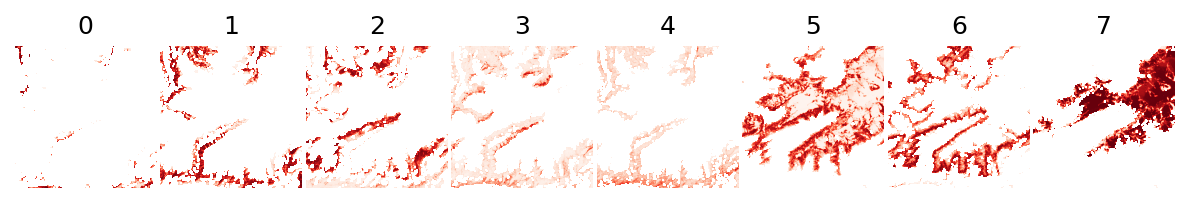

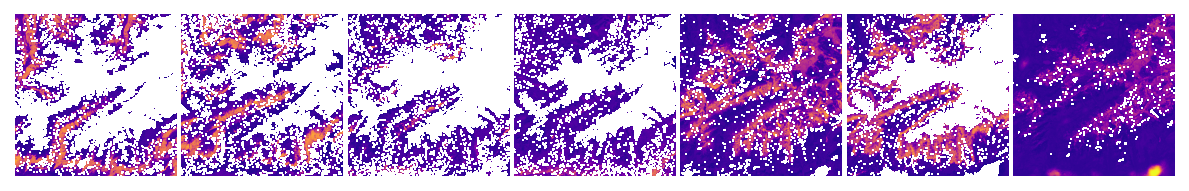

In [20]:
import numpy as np
from eumap.plotter import plot_rasters

lc_classes = [ int(c) for c in landmapper_eml.target_classes['transformed']]

plot_rasters(*output_fn_files[0:8], cmaps='Reds', titles=lc_classes)
plot_rasters(*output_fn_files[11:19], cmaps='plasma')

...and the dominant land cover:

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


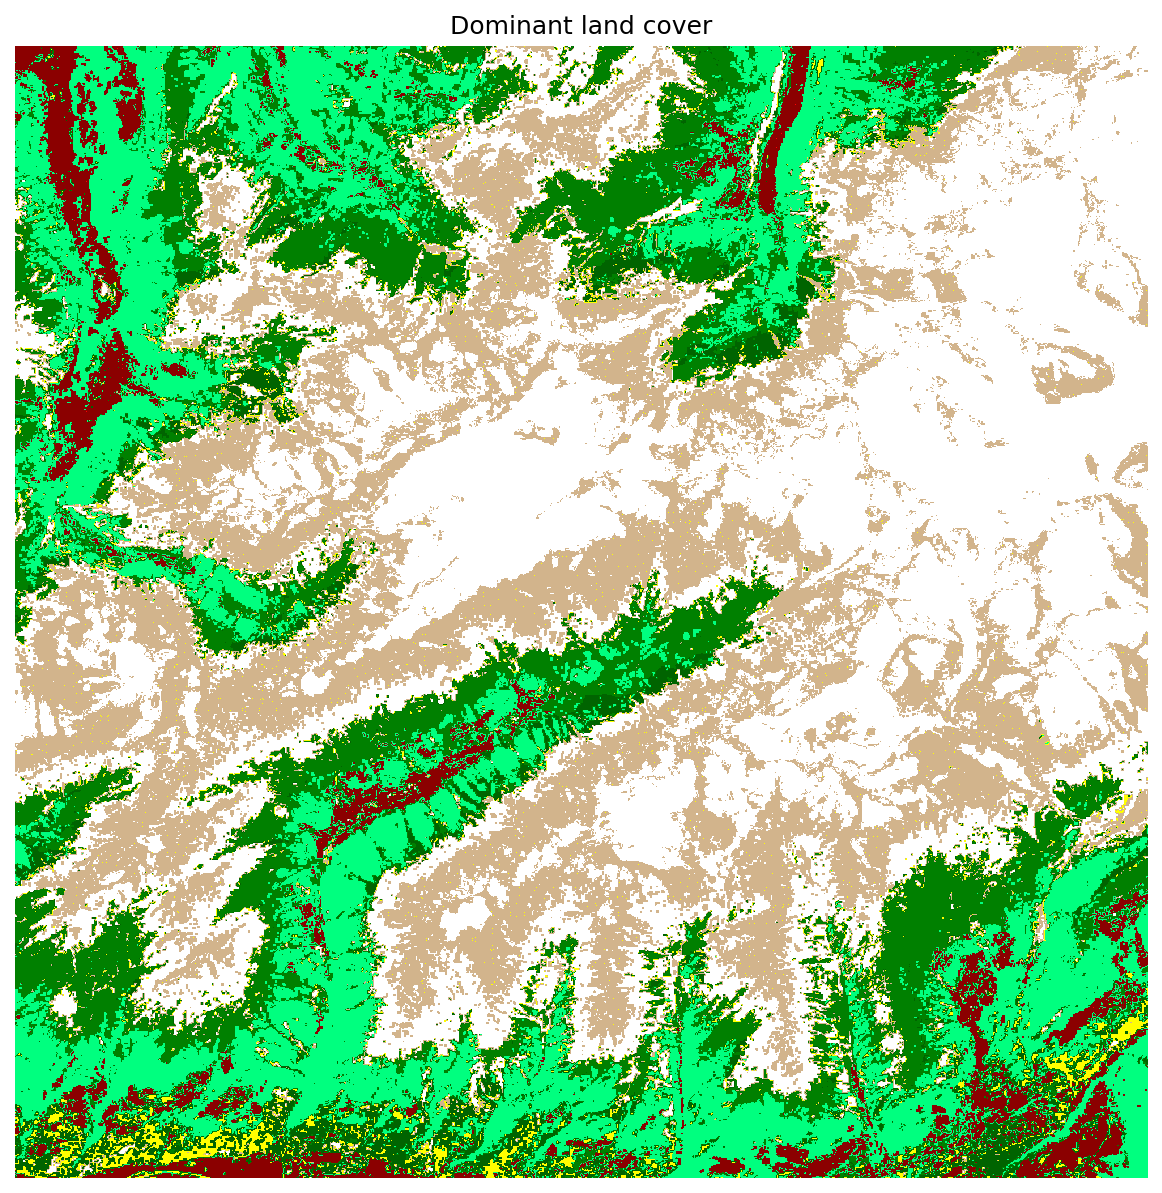

In [21]:
from eumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper_eml.target_classes['original']
pixel_values = landmapper_eml.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover')

Time to predict multiple years creating a list of **dirs_layers** and **fn_output** and passing to the method **predict_multi**, which will perform this task in parallel:

In [22]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 

dirs_layers_list = []
fn_output_list = []

for year in range(2000, 2003):
    dir_time_layers = os.path.join(data_dir, str(year))
    dirs_layers = [dir_time_layers, dir_timeless_layers]
    fn_result = os.path.join(data_dir, f'land_cover_eml_{year}.tif')
    
    dirs_layers_list.append(dirs_layers)
    fn_output_list.append(fn_result)

output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list, allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[16:21:00] Reading 87 raster files using 5 workers
[16:21:06] 1) Reading time: 5.78 segs
[16:21:06] 1) Predicting 1000000 pixels
[16:21:06] Reading 87 raster files using 5 workers
[16:21:06] Executing RandomForestClassifier
[16:21:09] RandomForestClassifier prediction time: 2.90 segs
[16:21:09] Executing XGBClassifier
[16:21:10] XGBClassifier prediction time: 0.63 segs
[16:21:10] Executing Pipeline
[16:21:10] batch_size=500000
[16:21:13] 2) Reading time: 6.72 segs
[16:21:13] Reading 87 raster files using 5 workers
[16:21:19] 3) Reading time: 5.90 segs
[16:21:51] Pipeline prediction time: 41.49 segs
[16:21:51] Executing LogisticRegression
[16:21:53] LogisticRegression prediction time: 1.46 segs
[16:21:53] 1) Predicting time: 46.53 segs
[16:21:53] 2) Predicting 1000000 pixels
[16:21:53] Executing RandomForestClassifier
[16:21:54] 1) Saving time: 1.19 segs
[16:21:56] RandomForestClassifier prediction time: 2.94 segs
[16:21:56] Executing XGBClassifier
[16:21:56] XGBClassifier prediction ti

The ``LandMapper`` also supports a **eager** prediction strategy that *reads all the years*, run the predictions for all the data *at once* and write the output files:

In [23]:
from eumap.mapper import PredictionStrategyType

pred_strategy_type = PredictionStrategyType.Eager
output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list, \
                                               allow_additional_layers=True, prediction_strategy_type=pred_strategy_type)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[16:23:29] Reading 87 raster files using 5 workers
[16:23:29] Reading 87 raster files using 5 workers
[16:23:29] Reading 87 raster files using 5 workers
[16:23:36] 2) Reading time: 7.37 segs
[16:23:36] 1) Reading time: 7.51 segs
[16:23:37] 3) Reading time: 8.33 segs
[16:23:37] 3) Predicting 3000000 pixels
[16:23:38] Executing RandomForestClassifier
[16:23:45] RandomForestClassifier prediction time: 7.27 segs
[16:23:45] Executing XGBClassifier
[16:23:46] XGBClassifier prediction time: 1.17 segs
[16:23:46] Executing Pipeline
[16:23:46] batch_size=1500000
[16:25:55] Pipeline prediction time: 128.80 segs
[16:25:55] Executing LogisticRegression
[16:25:59] LogisticRegression prediction time: 4.02 segs
[16:25:59] 3) Predicting time: 141.39 segs
[16:26:02] 2) Saving time: 2.22 segs
[16:26:02] 3) Saving time: 2.28 segs
[16:26:02] 1) Saving time: 2.35 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land

## Feature Selection

The ``LandMapper`` is fully compatible with scikit-learn, supporting any [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) implementations. 

To demonstrate it, we will develop from scratch a simple **random feature selection strategy**, which will randomly reduce the number of input features before the training step.

In [24]:
from numpy.random import default_rng
from sklearn.base import BaseEstimator, TransformerMixin

class RandomFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, n_features = 10, seed = 0):
        self.n_features = n_features
        self.rng = default_rng()
        self.seed = seed

    def fit(self, X, y):
        n_features = X.shape[1]
        self.rand_features = self.rng.choice(n_features, size=self.n_features, replace=False)
        return self

    def transform(self, X):
        return X[:,self.rand_features]

Now let's define the expected **number of features** (*there are 87 features in total*), changing the input ``seed`` to produce diferent subsets. The ``passthrough`` will indicate to the pipeline just move foward to the next step.

In [25]:
feature_sel = [
    RandomFeatureSelector(n_features=60, seed = 0),
    RandomFeatureSelector(n_features=70, seed = 0),
    RandomFeatureSelector(n_features=80, seed = 0),
    RandomFeatureSelector(n_features=60, seed = 1),
    RandomFeatureSelector(n_features=70, seed = 1),
    RandomFeatureSelector(n_features=80, seed = 1),
    'passthrough'
]

This time we will define our estimators as [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline), indicating the ``feature_sel`` step before them

In [26]:
estimator_rf = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85))
])

estimator_bgtree = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree'))
])

estimator_ann = Pipeline([
    ('feature_sel', 'passthrough'),
    ('standardize', StandardScaler()),
    ('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
        epochs=5, batch_size=64, learning_rate = 0.0005, \
        dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

...and adding the ``feature_sel`` possibilities as a property in our hyperparameter optimization class (GridSearchCV):

In [27]:
hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__max_depth': [5, None], 
     'estimator__max_features': [0.5, None]
    }
)

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__eta': [0.001, 0.9], 
     'estimator__alpha': [0, 10]
    }
)

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

Let's keep the **same** meta-estimator

In [28]:
meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial', C=1, fit_intercept=True)

... and ``LandMapper`` parameters:

In [29]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

landmapper_feat_sel = LandMapper(points=fn_points, 
                                feat_col_prfxs = feat_col_prfxs, 
                                target_col = target_col, 
                                estimator_list = [estimator_rf, estimator_bgtree, estimator_ann],
                                hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann],
                                meta_estimator = meta_estimator,
                                min_samples_per_class = min_samples_per_class,
                                cv = cv,
                                pred_method='predict_proba',
                                verbose = True)

landmapper_feat_sel.train()

[16:26:03] Removing 74 samples (lc_class in [111 122 133 512 221 211 311 132 334]) due min_samples_per_class condition (< 0.05)
[16:26:03] Transforming lc_class:
[16:26:03]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[16:26:03]  -Transformed classes: [0 1 2 3 4 5 6 7]
[16:26:03] Optimizing hyperparameters for Pipeline
Fitting 2 folds for each of 28 candidates, totalling 56 fits
[16:26:27]  1.04251 (+/-0.02247) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60)}
[16:26:27]  1.04864 (+/-0.02197) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=70)}
[16:26:27]  1.04673 (+/-0.00467) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=80)}
[16:26:27]  1.11012 (+/-0.02902) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:29:40]  Meta-features shape: (1050, 24)
[16:29:40] Calculating evaluation metrics
[16:29:40] Training Pipeline using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


[16:29:41] Training Pipeline using all samples
[16:29:41] Training Pipeline using all samples
[16:29:43] Training meta-estimator using all samples


Checking the output it's possible to see that **some variables** were **removed**. 

How it impacts the accuracy metrics?

In [30]:
print(f'Log loss: {landmapper_feat_sel.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_feat_sel.eval_report)

Log loss: 0.886


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.0064     0.7437   0.2395        0.7424              0.7424         66
1  0.7927     0.7624   0.4558        0.6884              0.6884         199
2  0.9185     0.7544   0.3900        0.7169              0.7169         166
3  1.4490     0.4829   0.2709        0.5000              0.5000         116
4  1.8869     0.2580   0.2257        0.3333              0.3333         84
5  0.7728     0.7785   0.3502        0.7426              0.7426         101
6  0.5454     0.8821   0.3906        0.8122              0.8122         229
7  0.2656     0.9665   0.4599        0.9326              0.9326         89

Total                                                                     1050



Even using less features in the estimator, the prediction needs receive the **full feature space** (*all rasters*), which will be reduced by the pipeline (``feature_sel`` step):

In [31]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_featsel_2000.tif')

output_fn_files = landmapper_feat_sel.predict(dirs_layers=dirs_layers, fn_output=fn_output, allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[16:29:43] Reading 87 raster files using 4 workers
[16:29:50] Executing Pipeline
[16:29:52] Pipeline prediction time: 2.75 segs
[16:29:52] Executing Pipeline
[16:29:54] Pipeline prediction time: 1.37 segs
[16:29:54] Executing Pipeline
[16:29:54] batch_size=500000
[16:30:36] Pipeline prediction time: 42.07 segs
[16:30:36] Executing LogisticRegression
[16:30:37] LogisticRegression prediction time: 1.41 segs
Output files:
 - land_cover_eml_featsel_2000_b1.tif
 - land_cover_eml_featsel_2000_b2.tif
 - land_cover_eml_featsel_2000_b3.tif
 - land_cover_eml_featsel_2000_b4.tif
 - land_cover_eml_featsel_2000_b5.tif
 - land_cover_eml_featsel_2000_b6.tif
 - land_cover_eml_featsel_2000_b7.tif
 - land_cover_eml_featsel_2000_b8.tif
 - land_cover_eml_featsel_2000_hcl.tif
 - land_cover_eml_featsel_2000_hcl_prob.tif
 - land_cover_eml_featsel_2000_uncertainty_b1.tif
 - land_cover_eml_featsel_2000_uncertainty_b2.tif
 - land_cover_eml_featsel_2000_uncertainty_b3.tif
 - land_cover_eml_featsel_2000_uncertain

## VotingClassifier

Next, we will construct a EML using a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html):

In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

voting_eml = VotingClassifier([
    ('rf', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85)),
    ('svm', SVC(probability=True, cache_size=1024)),
    ('xgb', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')),
], voting='soft')

hyperpar_voting_eml = GridSearchCV(
    estimator = voting_eml,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'svm__C': [1, 1.5],
     'svm__kernel': ['rbf', 'poly'],
     'xgb__eta': [0.001, 0.9], 
     'xgb__alpha': [0, 10],
     'rf__max_depth': [5, None], 
     'rf__max_features': [0.5, None]
    }
)

Time to train:

In [33]:
landmapper_vot = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = voting_eml,
                        hyperpar_selection = hyperpar_voting_eml,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        pred_method='predict_proba',
                        verbose = True)

landmapper_vot.train()

[16:30:38] Removing 74 samples (lc_class in [111 122 133 512 221 211 311 132 334]) due min_samples_per_class condition (< 0.05)
[16:30:38] Transforming lc_class:
[16:30:38]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[16:30:38]  -Transformed classes: [0 1 2 3 4 5 6 7]
[16:30:38] Optimizing hyperparameters for VotingClassifier
Fitting 2 folds for each of 64 candidates, totalling 128 fits
[16:33:07]  1.34409 (+/-0.00201) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.001}
[16:33:07]  0.94798 (+/-0.06110) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.9}
[16:33:07]  1.34917 (+/-0.00521) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 10, 'xgb__eta': 0.001}
[16:33:07]  1.12104 (+/-0.02364) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:33:09] Training VotingClassifier using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s finished


... and check the accuracy:

In [34]:
print(f'Log loss: {landmapper_vot.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_vot.eval_report)

Log loss: 0.872


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.7946     0.8532   0.3703        0.8030              0.8030         66
1  0.6680     0.7870   0.4704        0.7136              0.7136         199
2  0.9218     0.7994   0.3220        0.7349              0.7349         166
3  1.4884     0.5280   0.2349        0.5259              0.5259         116
4  1.9711     0.2903   0.1762        0.3333              0.3333         84
5  0.7740     0.8193   0.3334        0.7624              0.7624         101
6  0.6115     0.8947   0.4028        0.7948              0.7948         229
7  0.2306     0.9810   0.5485        0.9438              0.9438         89

Total                                                                     1050



## Saving/Loading the model(s)

For last, it's necessary to save the LandMapper instance, enabling to run **future predictions** without train the ML model(s) from scratch.

The method ``save_instance`` will do it for you using by default a [lz4](https://pypi.org/project/lz4/) compression:

In [35]:
fn_landmapper = os.path.join(data_dir, f'landmapper_eml.lz4')
landmapper_eml.save_instance(fn_landmapper)

It's also possible saves the instance removing the training data

In [36]:
fn_landmapper_thin = os.path.join(data_dir, f'landmapper_eml_thin.lz4')
landmapper_eml.save_instance(fn_landmapper_thin, no_train_data=True)

[16:33:11] Removing pts attribute
[16:33:11] Removing features attribute
[16:33:11] Removing target attribute
[16:33:11] Removing samples_weight attribute
[16:33:11] Removing cv_groups attribute


... and generating a smaller file:

In [37]:
from pathlib import Path
print("Model size:")
print(f' - {Path(fn_landmapper).stem}: {Path(fn_landmapper).stat().st_size / 1024 / 1024:.2f} MiB')
print(f' - {Path(fn_landmapper_thin).stem}: {Path(fn_landmapper_thin).stat().st_size / 1024 / 1024:.2f} MiB')

Model size:
 - landmapper_eml: 1.61 MiB
 - landmapper_eml_thin: 1.15 MiB


The generated ``*.h5`` files refer to KerasClassifier ([more information here](https://stackoverflow.com/a/40397312)).